In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('COCO COLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400
1,1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400
2,1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800
3,1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800
4,1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15096 entries, 0 to 15095
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15096 non-null  object 
 1   Open       15096 non-null  float64
 2   High       15096 non-null  float64
 3   Low        15096 non-null  float64
 4   Close      15096 non-null  float64
 5   Adj Close  15096 non-null  float64
 6   Volume     15096 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 825.7+ KB


In [ ]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
date = data['Date'].values
price = data['Close'].values

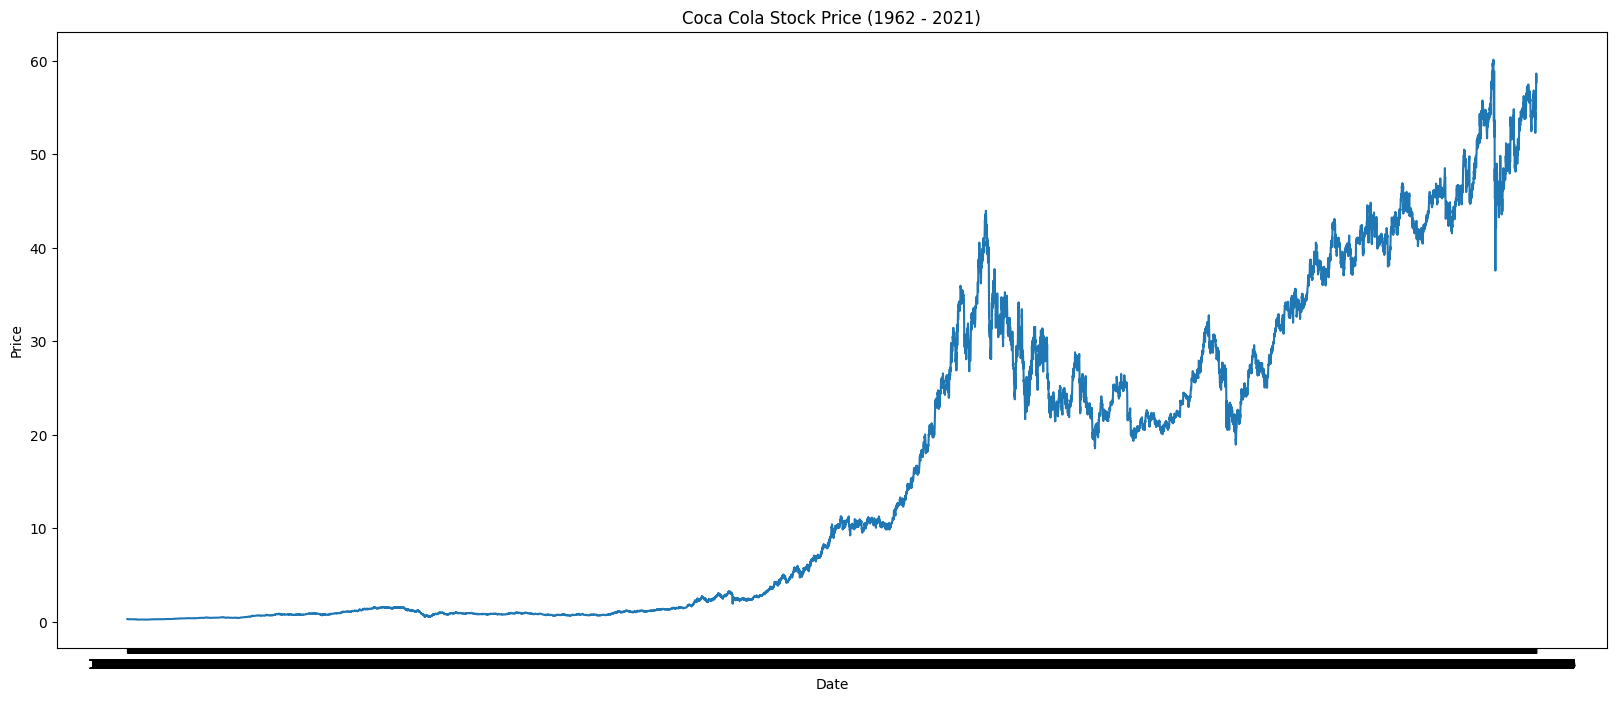

In [10]:
plt.figure(figsize=(20,8))
plt.plot(date, price)
plt.title('Coca Cola Stock Price (1962 - 2021)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [15]:
scaler = MinMaxScaler()
price_scaled = scaler.fit_transform(price.reshape(-1, 1)).flatten()

In [16]:
threshold = (price.max() - price.min()) * 10 / 100
print('Threshold MAE:', threshold)

Threshold MAE: 5.9937944000000005


In [17]:
x_train, x_test, y_train, y_test = train_test_split(price, date, test_size = 0.2)

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  data_series = tf.data.Dataset.from_tensor_slices(series)
  data_series = data_series.window(window_size + 1, shift=1, drop_remainder = True)
  data_series = data_series.flat_map(lambda w: w.batch(window_size + 1))
  data_series = data_series.shuffle(shuffle_buffer)
  data_series = data_series.map(lambda w: (w[:-1], w[-1:]))
  return data_series.batch(batch_size).prefetch(1)

In [19]:
data_training = windowed_dataset(x_train, window_size=64, batch_size=128, shuffle_buffer=1000)
data_testing = windowed_dataset(x_test, window_size=64, batch_size=128, shuffle_buffer=1000)

In [20]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
])

In [21]:
optimizers = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=["mae"])

In [22]:
class EarlyStoppingByMAE(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('mae') < threshold and logs.get('val_mae') < threshold:
            print("MAE and Val_MAE below threshold, stopping training")
            self.model.stop_training = True

callbacks = [EarlyStoppingByMAE()]

In [23]:
model_history = model.fit(
    data_training,
    epochs=50,
    validation_data=data_testing,
    callbacks=callbacks
)

Epoch 1/50
94/94 [==============================] - 29s 261ms/step - loss: 15.2636 - mae: 15.7047 - val_loss: 15.3951 - val_mae: 15.8013
Epoch 2/50
94/94 [==============================] - 22s 228ms/step - loss: 15.0296 - mae: 15.4700 - val_loss: 15.1323 - val_mae: 15.5401
Epoch 3/50
94/94 [==============================] - 23s 244ms/step - loss: 14.8706 - mae: 15.3230 - val_loss: 14.9644 - val_mae: 15.4083
Epoch 4/50
94/94 [==============================] - 23s 239ms/step - loss: 14.7728 - mae: 15.2297 - val_loss: 14.8505 - val_mae: 15.3247
Epoch 5/50
94/94 [==============================] - 23s 244ms/step - loss: 14.6681 - mae: 15.1298 - val_loss: 14.7648 - val_mae: 15.2506
Epoch 6/50
94/94 [==============================] - 20s 209ms/step - loss: 14.6247 - mae: 15.0901 - val_loss: 14.6965 - val_mae: 15.1820
Epoch 7/50
94/94 [==============================] - 22s 230ms/step - loss: 14.5724 - mae: 15.0377 - val_loss: 14.6360 - val_mae: 15.1220
Epoch 8/50
94/94 [=======================